In [1]:
import torch
from transformers import AutoConfig, AutoModelForCausalLM
from janus.models import MultiModalityCausalLM, VLChatProcessor
from janus.utils.io import load_pil_images
from PIL import Image

import numpy as np
import os
import time
model_path = 'deepseek-ai/Janus-Pro-1B'
config = AutoConfig.from_pretrained(model_path)
language_config = config.language_config
language_config._attn_implementation = 'eager'
vl_gpt = AutoModelForCausalLM.from_pretrained(model_path,
                                             language_config=language_config,
                                             trust_remote_code=True)

cuda_device = 'cuda' if torch.cuda.is_available() else 'cpu'
#cuda_device = 'cpu'
if cuda_device == 'cuda':
    vl_gpt = vl_gpt.to(torch.bfloat16).cuda()
else:
    vl_gpt = vl_gpt.to(torch.float16)

vl_chat_processor = VLChatProcessor.from_pretrained(model_path)
tokenizer = vl_chat_processor.tokenizer

def multimodal_understanding(image, question, seed, top_p, temperature):
    # Clear CUDA cache before generating
    torch.cuda.empty_cache()
    
    # set seed
    torch.manual_seed(seed)
    np.random.seed(seed)
    torch.cuda.manual_seed(seed)
    
    conversation = [
        {
            "role": "<|User|>",
            "content": f"<image_placeholder>\n{question}",
            "images": [image],
        },
        {"role": "<|Assistant|>", "content": ""},
    ]
    
    pil_images = load_pil_images(conversation)
    prepare_inputs = vl_chat_processor(
        conversations=conversation, images=pil_images, force_batchify=True
    ).to(cuda_device, dtype=torch.bfloat16 if torch.cuda.is_available() else torch.float16)
    
    
    inputs_embeds = vl_gpt.prepare_inputs_embeds(**prepare_inputs)
    
    outputs = vl_gpt.language_model.generate(
        inputs_embeds=inputs_embeds,
        attention_mask=prepare_inputs.attention_mask,
        pad_token_id=tokenizer.eos_token_id,
        bos_token_id=tokenizer.bos_token_id,
        eos_token_id=tokenizer.eos_token_id,
        max_new_tokens=512,
        do_sample=False if temperature == 0 else True,
        use_cache=True,
        temperature=temperature,
        top_p=top_p,
    )
    
    answer = tokenizer.decode(outputs[0].cpu().tolist(), skip_special_tokens=True)
    return answer


/home/rmuproject/rmuproject/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Python version is above 3.10, patching the collections module.


/home/rmuproject/rmuproject/.venv/lib/python3.10/site-packages/transformers/models/auto/image_processing_auto.py:594: FutureWarning: The image_processor_class argument is deprecated and will be removed in v4.42. Please use `slow_image_processor_class`, or `fast_image_processor_class` instead
  warnings.warn(
Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.48, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.
You are using the default legacy behaviour of the <class 'transformers.models.llama.tokenization_llama_fast.LlamaTokenizerFast'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and tho

In [2]:
from IPython.display import display
from urllib.request import urlopen
from glob import glob
image_path = '/home/rmuproject/rmuproject/users/sandesh/Depth-to-Image/Fine-tune-DreamBooth/Input/input_24.jpg'
# init_image = Image.open(image_path).convert("RGB")
# image_path_list = glob(image_path + '/*')
prompt1 = 'Describe the image in detail, focusing on the inner loops, textures, and intricate structures. Be specific about the patterns and fine details.'
prompt2 = 'Describe the image in two sentence with a focus on the inner loops and intricate details. Use terms like sharp focus, 4k detailed, 4k definition, 4k quality, and different colors to highlight the fine textures and complex patterns.'
image_description = multimodal_understanding (
    image = image_path,
    question=prompt2,
    seed = 123,
    top_p = 0.8,
    temperature = 1.0
   )
print(image_description)

The image depicts a highly detailed frame with a sharp focus on its intricate floral and leafy patterns. The frame's corners are adorned with a blend of brown, orange, and gold hues, creating a luxurious and artistic appearance.


In [3]:
# Names of variables to keep
keep_variables = ['image_description', 'image_to_generate']

# Iterate over a copy of globals() to avoid modifying it while iterating
for var in list(globals().keys()):
    # Skip special variables and keep specified ones
    if var not in keep_variables and not var.startswith('__'):
        del globals()[var]

print("Cleared all global variables except:", image_description)


Cleared all global variables except: The image depicts a highly detailed frame with a sharp focus on its intricate floral and leafy patterns. The frame's corners are adorned with a blend of brown, orange, and gold hues, creating a luxurious and artistic appearance.


In [4]:
import torch
import requests
from PIL import Image

from diffusers import StableDiffusionDepth2ImgPipeline
model_path = '/home/rmuproject/rmuproject/users/sandesh/Depth-to-Image/Fine-tune-DreamBooth/sd-depth-output'
model_path2 = '/home/rmuproject/rmuproject/users/sandesh/Depth-to-Image/Fine-tune-DreamBooth/outputs'
pipe = StableDiffusionDepth2ImgPipeline.from_pretrained(
    # 'stabilityai/stable-diffusion-2-depth',
    model_path2,
    torch_dtype=torch.float16,
).to("cuda")
pipe.enable_model_cpu_offload()

Loading pipeline components...: 100%|██████████| 7/7 [00:01<00:00,  6.78it/s]


Jupyter compare_view v0.2.4



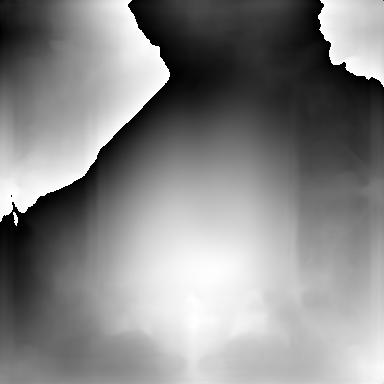
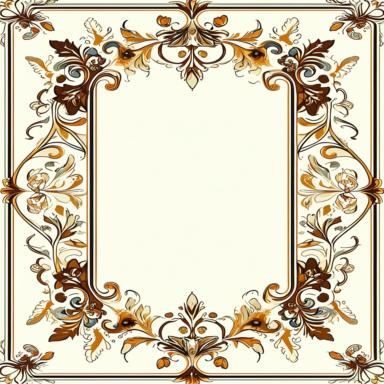

In [5]:
import PIL
import torch
from torchvision import transforms
import diffusers
import transformers
import os
from jupyter_compare_view import compare

# Use an image as an input depth map
image_path = '/home/rmuproject/rmuproject/users/sandesh/Depth-to-Image/Fine-tune-DreamBooth/Input/input_24.jpg'  # replace with your path
image = PIL.Image.open(image_path).convert("RGB")

# Define transformations (without dtype)
image_transform = transforms.Compose([
    transforms.Resize((384, 384)),
    transforms.ToTensor()
])

# Apply transformations
image = image_transform(image)

# Convert to float16 and add batch dimension
image = image.to(dtype=torch.float16).unsqueeze(0).to("cuda")

# Depth estimation pipeline (make sure `pipe` is defined)
depth_map = pipe.depth_estimator(image).predicted_depth

# Convert image back to PIL
image_pil = transforms.ToPILImage()(image[0].cpu())

# Normalize depth map
depth_min = torch.amin(depth_map, dim=[0, 1, 2], keepdim=True)
depth_max = torch.amax(depth_map, dim=[0, 1, 2], keepdim=True)
depth_map = 2.0 * (depth_map - depth_min) / (depth_max - depth_min) - 1.0
depth_map = depth_map[0, :, :]

# Convert depth map to PIL
depth_map_pil = transforms.ToPILImage()(depth_map.cpu())

# Compare images
from IPython.display import display

compare_result = compare(depth_map_pil, image_pil, cmap="gray", start_mode="horizontal", start_slider_pos=0.73)
display(compare_result)



100%|██████████| 20/20 [00:10<00:00,  2.00it/s]


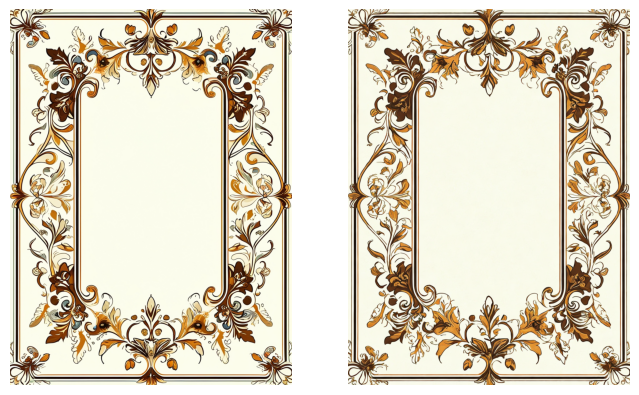

In [6]:
image_path = '/home/rmuproject/rmuproject/users/sandesh/Depth-to-Image/Fine-tune-DreamBooth/Input/input_24.jpg'
init_image = Image.open(image_path).convert("RGB")
prompt = 'good colors, sharp definition'+image_description  
n_prompt = "bad, deformed, ugly, bad anotomy, bad resolution, bad quality, bad asthetic, blurry"
seed = 123
generator = torch.Generator(device="cuda").manual_seed(seed)
image = pipe(prompt=prompt, image=init_image, negative_prompt=n_prompt, strength=0.4, guidance_scale=7, generator=generator).images[0]
image.save("generated_image.png")

# Display the image
# image.show()
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 2, figsize=(8, 12))
ax[0].imshow(init_image)
ax[1].imshow(image)
ax[0].axis("off")
ax[1].axis("off")
plt.show()

In [7]:
# Names of variables to keep
keep_variables = ['image_description', 'image_to_generate']

# Iterate over a copy of globals() to avoid modifying it while iterating
for var in list(globals().keys()):
    # Skip special variables and keep specified ones
    if var not in keep_variables and not var.startswith('__'):
        del globals()[var]

print("Cleared all global variables except:", image_description)


Cleared all global variables except: The image depicts a highly detailed frame with a sharp focus on its intricate floral and leafy patterns. The frame's corners are adorned with a blend of brown, orange, and gold hues, creating a luxurious and artistic appearance.


In [8]:
import torch
from diffusers import StableDiffusionXLImg2ImgPipeline
from diffusers.utils import load_image

pipe = StableDiffusionXLImg2ImgPipeline.from_pretrained(
    "stabilityai/stable-diffusion-xl-refiner-1.0", torch_dtype=torch.float16, variant="fp16", use_safetensors=True
)
pipe = pipe.to("cuda")
pipe.enable_model_cpu_offload()
from PIL import Image
image = Image.open("generated_image.png").convert("RGB")
prompt = image_description
image = pipe(prompt= 'Fill the bright colors', image=image, requires_aesthetics_score = True).images[0]
image.save("refined_image.png")


100%|██████████| 15/15 [00:09<00:00,  1.61it/s]


In [ ]:
import cv2
import numpy as np

# Load the image
img = cv2.imread("generated_image.png")

if img is None:
    raise FileNotFoundError("Error: Image not found or could not be loaded.")

def unsharp_mask(image, sigma=1.0, amount=1.5, threshold=0):
    blurred = cv2.GaussianBlur(image, (0, 0), sigma)
    sharpened = cv2.addWeighted(image, 1 + amount, blurred, -amount, 0)
    return sharpened

sharpened = unsharp_mask(img)

cv2.imwrite("sharpened_image.png", sharpened)
print("Sharpened image saved successfully.")


Sharpened image saved successfully.


In [14]:
import cv2
import numpy as np

def high_pass_filter(image):
    kernel = np.array([[-1, -1, -1],
                       [-1,  8, -1],
                       [-1, -1, -1]])
    high_pass = cv2.filter2D(image, -1, kernel)
    return high_pass

# Load the image
img = cv2.imread("generated_image.png")

if img is None:
    raise FileNotFoundError("Error: Image not found or could not be loaded.")

high_pass = high_pass_filter(img)

# Save the high-pass filtered image
cv2.imwrite("high_pass.png", high_pass)
print("High-pass filtered image saved successfully.")


High-pass filtered image saved successfully.


In [16]:
import cv2
import numpy as np

# Load the image
img = cv2.imread("generated_image.png")

if img is None:
    raise FileNotFoundError("Error: Image not found or could not be loaded.")

# Apply bilateral filter
filtered = cv2.bilateralFilter(img, d=9, sigmaColor=75, sigmaSpace=75)

# Check if filtered is valid
if filtered is None:
    raise ValueError("Error: Bilateral filter output is None.")

# Save the filtered image
success = cv2.imwrite("bilateral.png", filtered)
if not success:
    raise IOError("Error: Failed to save the filtered image.")

print("Bilateral filtered image saved successfully.")


Bilateral filtered image saved successfully.
